### Import

In [15]:
import os
import numpy as np
from tqdm import tqdm
from timm import create_model
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
import torchvision
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
import torchvision.models as models
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, average_precision_score, classification_report, ConfusionMatrixDisplay

### Data



In [16]:
transform = Compose([
    Resize((224, 224)),  # 調整到模型需求的輸入大小
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 常見正規化數值
])

train_ds = torchvision.datasets.ImageFolder('../0_data/0_rawDataSet/RSCD dataset-1million/train', transform=transform)
valid_ds = torchvision.datasets.ImageFolder('../0_data/0_rawDataSet/RSCD dataset-1million/vali_20k', transform=transform)
test_ds  = torchvision.datasets.ImageFolder('../0_data/0_rawDataSet/RSCD dataset-1million/test_50k', transform=transform)

### Model

In [17]:
NUM_CLASSES = len(train_ds.class_to_idx)

alexnet = models.alexnet(pretrained=False, num_classes=NUM_CLASSES)

vgg16 = models.vgg16(pretrained=False)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, NUM_CLASSES)
batch_norm = False  # 預設為 False
init_weights = True  # 預設為 True

googlenet = models.googlenet(pretrained=False, aux_logits=True, transform_input=False)# 3. GoogleLeNet (Inception v1)
googlenet.fc = nn.Linear(googlenet.fc.in_features, NUM_CLASSES)
googlenet.aux1.fc2 = nn.Linear(googlenet.aux1.fc2.in_features, NUM_CLASSES)  # 修改輔助分類器
googlenet.aux2.fc2 = nn.Linear(googlenet.aux2.fc2.in_features, NUM_CLASSES)

resnet18 = models.resnet18(pretrained=False, zero_init_residual=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, NUM_CLASSES)

squeezenet = models.squeezenet1_0(pretrained=False, num_classes=NUM_CLASSES)
squeezenet.classifier[1] = nn.Conv2d(512, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))

mobilenet_v2 = models.mobilenet_v2(pretrained=False, width_mult=1.0, round_nearest=8)
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.classifier[1].in_features, NUM_CLASSES)

efficientnet_b0 = models.efficientnet_b0(pretrained=False)
efficientnet_b0.classifier[1] = nn.Linear(efficientnet_b0.classifier[1].in_features, NUM_CLASSES)

swin_transformer = models.swin_t(pretrained=False, num_classes=NUM_CLASSES)
swin_transformer.head = nn.Linear(swin_transformer.head.in_features, NUM_CLASSES)
embed_dim = 96  # 預設
depths = [2, 2, 6, 2]  # 預設
num_heads = [3, 6, 12, 24]  # 預設
window_size = 7  # 預設
drop_path_rate = 0.1  # 預設
ape = False  # 預設
patch_norm = True  # 預設

xception = create_model('xception', pretrained=False, num_classes=NUM_CLASSES, drop_rate=0.2)

convnext_tiny = create_model('convnext_tiny', pretrained=False, num_classes=NUM_CLASSES, drop_path_rate=0.1)

mnasnet = models.mnasnet1_0(pretrained=False)
mnasnet.classifier[1] = nn.Linear(mnasnet.classifier[1].in_features, NUM_CLASSES)

c:\Users\YunChung\miniconda3\envs\eenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\YunChung\miniconda3\envs\eenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\YunChung\miniconda3\envs\eenv\lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
c:\Users\YunChung\miniconda3\envs\eenv\lib\site-packages\timm\models\_factory.py:117: UserWarning:

### Training Parameters

In [18]:
# Model
weights_dir = '../2_results/0_weight'
weights_files = [f for f in os.listdir(weights_dir) if f.endswith('.pt')]

print("Available weights files:")
for i, f in enumerate(weights_files):
    print(f"{i}: {f}")

# 選擇一個權重檔案
selected_index = int(input("Enter the index of the weight file to load: "))
selected_weight = os.path.join(weights_dir, weights_files[selected_index])
print(f"Selected weight file: {selected_weight}")

model = torch.load(selected_weight)

num_workers = 4

Available weights files:
0: AlexNet_0.43_epoch1_batchSize256_lr1e-03.pt
1: AlexNet_0.54_epoch1_batchSize256_lr1e-03.pt
2: AlexNet_0.64_epoch20_batchSize256_lr1e-03.pt
3: EfficientNet_0.81_epoch1_batchSize32_lr1e-03.pt
4: MNASNet_0.64_epoch1_batchSize64_lr1e-03.pt
5: MobileNetV2_0.84_epoch1_batchSize32_lr1e-03.pt
6: ResNet_0.70_epoch1_batchSize64_lr1e-03.pt
7: SqueezeNet_0.64_epoch1_batchSize64_lr1e-03.pt
8: SwinTransformer_0.00_epoch1_batchSize16_lr1e-03.pt
9: Xception_0.56_epoch1_batchSize16_lr1e-03.pt
Selected weight file: ../2_results/0_weight\AlexNet_0.43_epoch1_batchSize256_lr1e-03.pt


C:\Users\YunChung\AppData\Local\Temp\ipykernel_10232\1643025587.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(selected_weight)


### Setup

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda()

### EVALUATE

Evaluating: 100%|██████████| 311/311 [00:44<00:00,  7.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3644148..1.2456646].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4157891..1.2979523].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4500387..1.2630938].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6384109..1.6116778].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6897851..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5870366..1.2108063].
Clipping input data to the valid range for imshow with RGB data ([0..

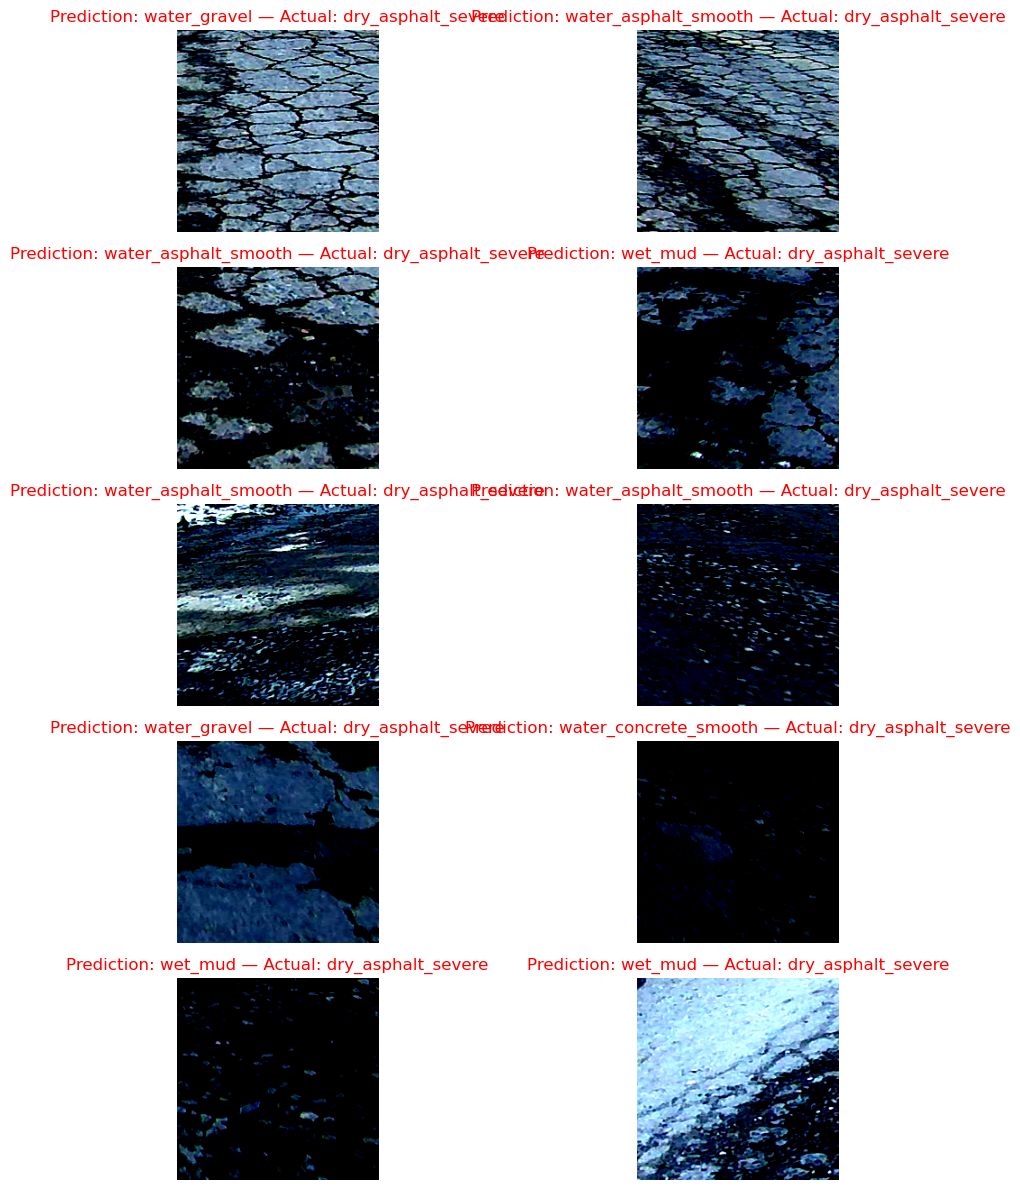

In [20]:
EVAL_BATCH = 64
eval_loader = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=False, num_workers=num_workers)

predicted_classes = []
target_classes = []
original_inputs = []

# 禁用梯度以加速推理
with torch.no_grad():
    for inputs, targets in tqdm(eval_loader, desc="Evaluating"):
        # 將資料移動到設備
        inputs = inputs.to(device)
        targets = targets.to(device)

        # 進行推理
        outputs = model(inputs)  # 前向傳播
        predicted_classes.extend(outputs.argmax(dim=1).cpu().tolist())  # 收集預測類別
        target_classes.extend(targets.cpu().tolist())  # 收集真實類別

        # 儲存前 10 張影像的原始輸入
        if len(original_inputs) < 10:
            original_inputs.extend(inputs.cpu().permute(0, 2, 3, 1).numpy())

# 顯示前 10 張影像
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.imshow(original_inputs[i])
    pred_label = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_classes[i])]
    true_label = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target_classes[i])]

    # 使用紅色標記錯誤，黑色標記正確
    color = "red" if pred_label != true_label else "black"
    plt.title(f"Prediction: {pred_label} — Actual: {true_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Indicator

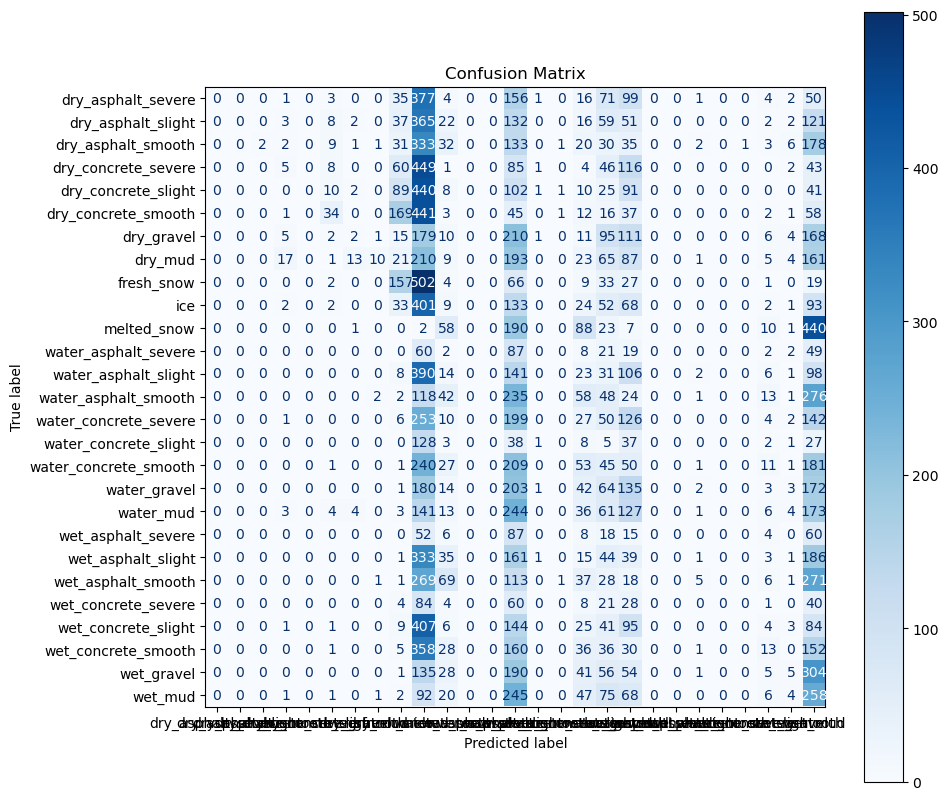

Precision: 0.1265
Recall: 0.0645
F1-score: 0.0376
mAP: 0.0407

Classification Report:
                        precision    recall  f1-score   support

   dry_asphalt_severe       0.00      0.00      0.00       820
   dry_asphalt_slight       0.00      0.00      0.00       820
   dry_asphalt_smooth       1.00      0.00      0.00       820
  dry_concrete_severe       0.12      0.01      0.01       820
  dry_concrete_slight       0.00      0.00      0.00       820
  dry_concrete_smooth       0.39      0.04      0.07       820
           dry_gravel       0.08      0.00      0.00       820
              dry_mud       0.62      0.01      0.02       820
           fresh_snow       0.23      0.19      0.21       820
                  ice       0.06      0.49      0.10       820
          melted_snow       0.12      0.07      0.09       820
 water_asphalt_severe       0.00      0.00      0.00       250
 water_asphalt_slight       0.00      0.00      0.00       820
 water_asphalt_smooth       0.

c:\Users\YunChung\miniconda3\envs\eenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\YunChung\miniconda3\envs\eenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\YunChung\miniconda3\envs\eenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [21]:
# Confusion Matrix
class_names = list(valid_ds.class_to_idx.keys())
cm = confusion_matrix(target_classes, predicted_classes, labels=range(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

fig = disp.ax_.get_figure()     # 調整大小
fig.set_figwidth(10)
fig.set_figheight(10)

plt.title("Confusion Matrix")   # 繪製
plt.show()

# Precision, Recall, F1-score
precision = precision_score(target_classes, predicted_classes, average='macro')
recall = recall_score(target_classes, predicted_classes, average='macro')
f1 = f1_score(target_classes, predicted_classes, average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# mAP
binary_targets = np.eye(len(class_names))[target_classes]
binary_predictions = np.eye(len(class_names))[predicted_classes]
mAP = average_precision_score(binary_targets, binary_predictions, average='macro')
print(f"mAP: {mAP:.4f}")

# Classification Report
report = classification_report(
    target_classes,
    predicted_classes,
    target_names=class_names,
    labels=list(range(len(class_names)))  # 指定完整類別範圍
)
print("\nClassification Report:\n", report)

Precision: 0.4876
Recall: 0.4383
F1-score: 0.4047
mAP: 0.2481